In [1]:
import sys

sys.path.append("/media/cyprien/Data/Documents/Github/pytorch-forecasting")

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import notebook

from pytorch_forecasting import Baseline
from utilities import *

from tqdm.notebook import tqdm

%matplotlib inline
sns.set_style("whitegrid")
notebook.tqdm().pandas()

pl.seed_everything(42)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


0it [00:00, ?it/s]

Global seed set to 42


42

In [2]:
config = load_config("../config/config.yml")
config

{'device': 'cpu',
 'seed': False,
 'model': 'rnn',
 'data': {'save': '../data/save/',
  'suppl': '../data/suppl/',
  'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/',
  'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/',
  'financials': 'financials.csv',
  'stock_prices': 'stock_prices.csv',
  'options': 'options.csv',
  'secondary_stock_price': 'secondary_stock_price.csv',
  'trades': 'trades.csv',
  'cosine': 'cosine_df.csv'},
 'rnn': {'sliding_window': {'max_prediction_length': 10,
   'min_prediction_length': 10,
   'max_encoder_length': 50,
   'min_encoder_length': 50,
   'batch_size': 64},
  'train_val_split': 0.95,
  'related_stock': 2,
  'manual_scale': True,
  'hidden_size': 20,
  'layers': 3,
  'dropout': 0},
 'gmm': {'path': './cache/', 'n_clusters': 4},
 'optimizer': {'name': 'adam',
  'epochs': 10,
  'params': {'lr': 0.001, 'regularization': 0.0001}}}

In [3]:
dl = StockPricesLoader(use_previous_files=True)

INFO:data_factory.dataLoader:../data/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv loaded. shape (2332531, 12)
INFO:data_factory.dataLoader:../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv loaded. shape (112000, 12)
INFO:data_factory.dataLoader:Missing targets dropped
INFO:data_factory.dataLoader:ExpectedDividend filled with 0. other values filled with ffill
DEBUG:data_factory.preprocessing:Fill grp 1301. shape: (1142, 15)
DEBUG:data_factory.preprocessing:Fill grp 1301 Done. shape: (1707, 14)
DEBUG:data_factory.preprocessing:Fill grp 1332. shape: (1142, 15)
DEBUG:data_factory.preprocessing:Fill grp 1332 Done. shape: (1707, 14)
DEBUG:data_factory.preprocessing:Fill grp 1333. shape: (1142, 15)
DEBUG:data_factory.preprocessing:Fill grp 1333 Done. shape: (1707, 14)
DEBUG:data_factory.preprocessing:Fill grp 1375. shape: (282, 15)
DEBUG:data_factory.preprocessing:Fill grp 1375 Done. shape: (421, 14)
DEBUG:data_factory.preprocessing:Fill grp 1

## Baseline Model

### Test set

In [4]:
actuals = torch.cat([y for x, (y, weight) in tqdm(iter(dl.test_dl))])
baseline_predictions = Baseline().predict(dl.test_dl)
print((actuals - baseline_predictions).abs().mean().item())

baseline_predictions_np = baseline_predictions.cpu().detach().numpy()
actuals_np = actuals.cpu().detach().numpy()

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpcql1tomz
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpcql1tomz/_remote_module_non_sriptable.py
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


0.18944819271564484


In [5]:
df_test_res_baseline = dl.df_test_ppc.copy()

df_test_res_baseline['close_true'] = actuals_np[:, 0].flatten()
df_test_res_baseline['close_pred'] = baseline_predictions_np[:, 0].flatten()
df_test_res_baseline['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res_baseline['target_pred'] = (baseline_predictions_np[:, 1] - baseline_predictions_np[:, 0]) / baseline_predictions_np[:, 0]
df_test_res_baseline.loc[:, ['Close', 'Close_scaled', 'close_true', 'close_pred', 'Target', 'target_true', 'target_pred']]

/tmp/ipykernel_229003/20393842.py:5: RuntimeWarning: invalid value encountered in true_divide
  df_test_res_baseline['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]


,Close,Close_scaled,close_true,close_pred,Target,target_true,target_pred
0,2971.0,-0.280201,-0.043818,-0.280201,-0.003263,0.573898,-0.0
1,3065.0,-0.043818,-0.068965,-0.043818,0.009820,-1.093905,-0.0
2,3055.0,-0.068965,0.006476,-0.068965,0.006483,7.766066,-0.0
3,3085.0,0.006476,0.056770,0.006476,-0.006441,0.000000,0.0
4,3105.0,0.056770,0.056770,0.056770,-0.008104,0.000000,0.0
...,...,...,...,...,...,...,...
169995,719.0,-1.029029,-0.975419,-1.029029,0.001364,-0.000000,-0.0
169996,733.0,-0.975419,-0.975419,-0.975419,-0.001362,-0.000000,-0.0
169997,733.0,-0.975419,-0.975419,-0.975419,-0.001362,-0.003926,-0.0
169998,733.0,-0.975419,-0.971590,-0.975419,-0.001362,-1.000000,-0.0


## RNN

In [6]:
from pytorch_forecasting.models.rnn import RecurrentNetwork

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

args = dict(
    hidden_size=config['rnn']['hidden_size'],
    rnn_layers=config['rnn']['layers'],
    dropout=config['rnn']['dropout']
)

# configure network and trainer
trainer = pl.Trainer(
    accelerator='gpu',
    gradient_clip_val=0.1,
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    auto_lr_find=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    weights_summary="top",
)

rnn = RecurrentNetwork.from_dataset(
    dl.df_train_timeseries,
    **args
)

# rnn = RecurrentNetwork.load_from_checkpoint('././lightning_logs/lightning_logs/version_5/checkpoints/epoch=0-step=49915.ckpt')

print(f"Number of parameters in network: {rnn.size() / 1e3:.1f}k")

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 216.9k


/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


#### Train the model

In [7]:
# # fit network

fit = True

if fit:
    trainer.fit(rnn, train_dataloaders=dl.train_dl, val_dataloaders=dl.val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 200 K 
3 | rnn              | LSTM           | 16.9 K
4 | output_projector | Linear         | 21    
----------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.868     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Results

In [8]:
import numpy as np

actuals = torch.cat([y for _, (y, _) in tqdm(iter(dl.test_dl))])
predictions = trainer.predict(rnn, (X for X, (y, _) in dl.test_dl))

predictions_np = np.array([i.prediction.numpy() for i in predictions]).squeeze(axis=3).reshape(-1, 10)
actuals_np = actuals.cpu().detach().numpy()

  0%|          | 0/2000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3979it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [9]:
actuals_unscaled = actuals_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, 10).copy()
predictions_unscaled = predictions_np.reshape(dl.df_train_ppc.SecuritiesCode.unique().size, -1, 10).copy()

for i, scaler in enumerate(dl.scalers):
    actuals_unscaled[i] = scaler.inverse_transform(actuals_unscaled[i])
for i, scaler in enumerate(dl.scalers):
    predictions_unscaled[i] = scaler.inverse_transform(predictions_unscaled[i])

actuals_unscaled = actuals_unscaled.reshape(-1, 10)
predictions_unscaled = predictions_unscaled.reshape(-1, 10)

In [10]:

df_test_res = dl.df_test_ppc.copy()

df_test_res['close_true'] = actuals_np[:, 0].flatten()
df_test_res['close_pred'] = predictions_np[:, 0].flatten()

df_test_res['close_true_unscaled'] = actuals_unscaled[:, 0].flatten()
df_test_res['close_pred_unscaled'] = predictions_unscaled[:, 0].flatten()

df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]
df_test_res['target_pred'] = (predictions_np[:, 1] - predictions_np[:, 0]) / predictions_np[:, 0]

df_test_res['target_true_unscaled'] = (actuals_unscaled[:, 1] - actuals_unscaled[:, 0]) / actuals_unscaled[:, 0]
df_test_res['target_pred_unscaled'] = (predictions_unscaled[:, 1] - predictions_unscaled[:, 0]) / predictions_unscaled[:, 0]

df_test_res.loc[:, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']]


/tmp/ipykernel_229003/1863756519.py:9: RuntimeWarning: invalid value encountered in true_divide
  df_test_res['target_true'] = (actuals_np[:, 1] - actuals_np[:, 0]) / actuals_np[:, 0]


,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
0,2971.0,3065.000000,2975.882812,-0.003263,-0.003263,-0.004199
1,3065.0,3055.000000,3036.101562,0.009820,0.009820,0.000348
2,3055.0,3085.000000,3052.726318,0.006483,0.006483,-0.002633
3,3085.0,3105.000000,3071.613037,-0.006441,0.000000,-0.002695
4,3105.0,3105.000000,3091.452881,-0.008104,0.000000,-0.002638
...,...,...,...,...,...,...
169995,719.0,733.000000,721.644531,0.001364,0.000000,0.000863
169996,733.0,733.000000,730.031616,-0.001362,0.000000,0.000979
169997,733.0,733.000000,732.998901,-0.001362,0.001364,0.000423
169998,733.0,734.000000,733.588806,-0.001362,0.345674,0.000546


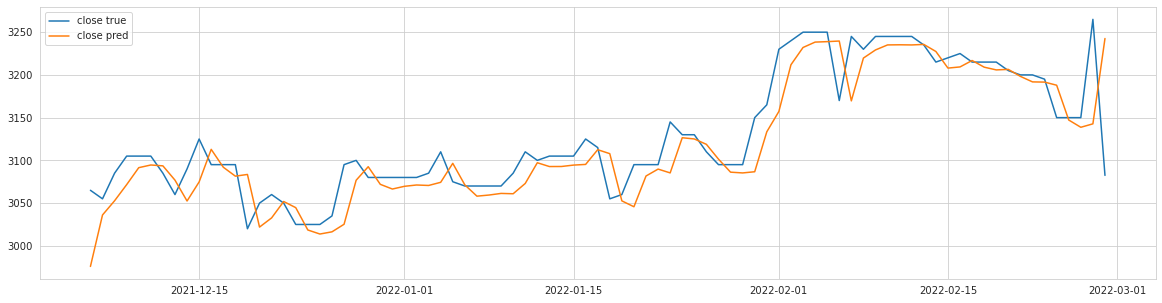

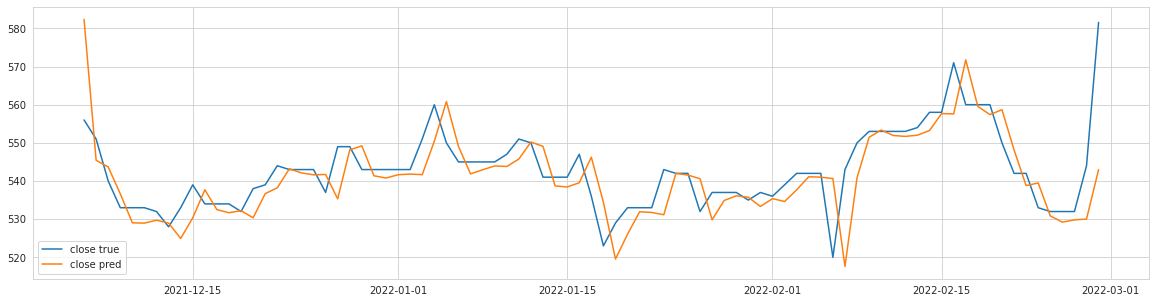

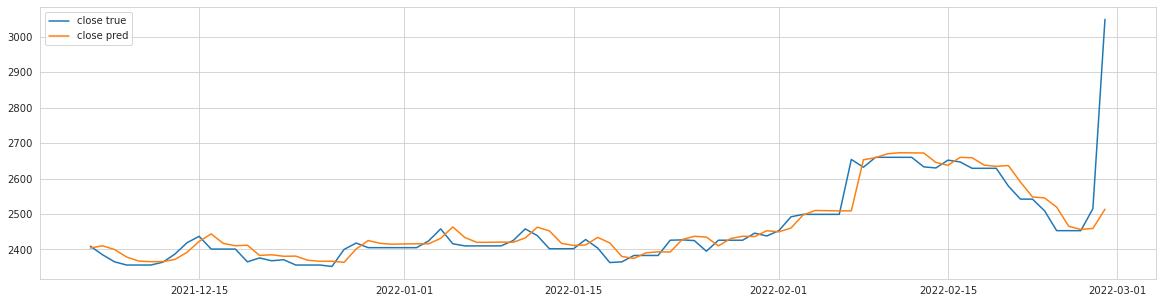

In [18]:
import matplotlib.pyplot as plt

for sc in dl.df_train_ppc.SecuritiesCode.unique()[:3]:
    df = df_test_res[df_test_res.SecuritiesCode == sc]
    figure = plt.figure(figsize=(20, 5))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df.Date, df.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df.Date, df.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

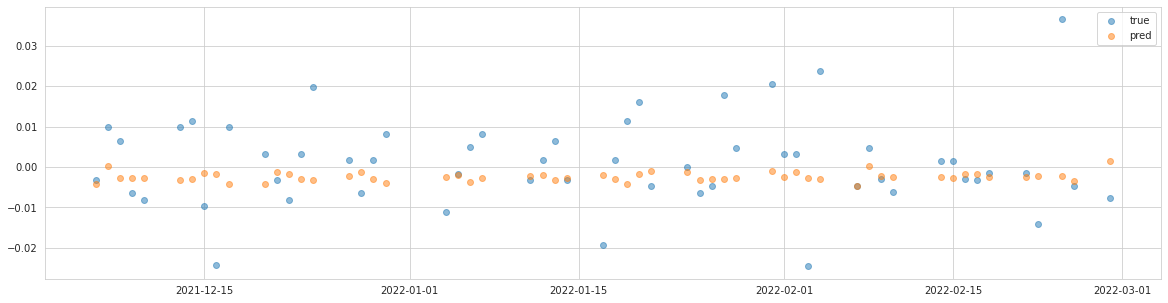

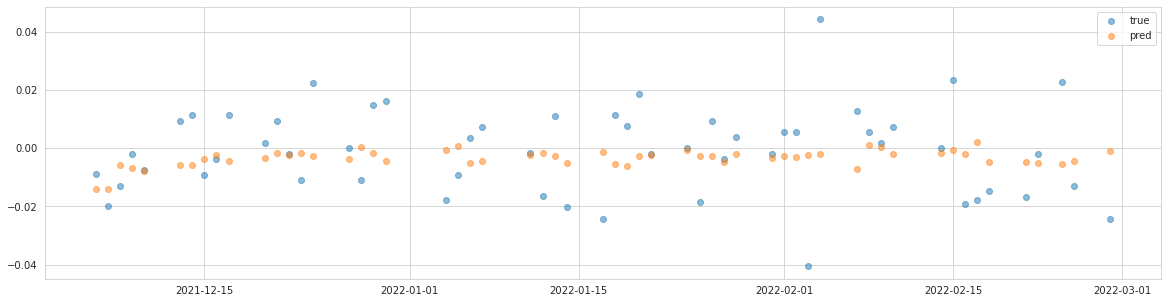

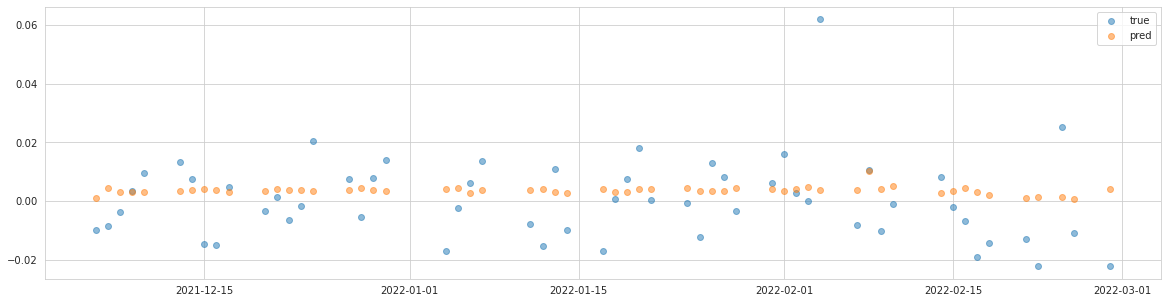

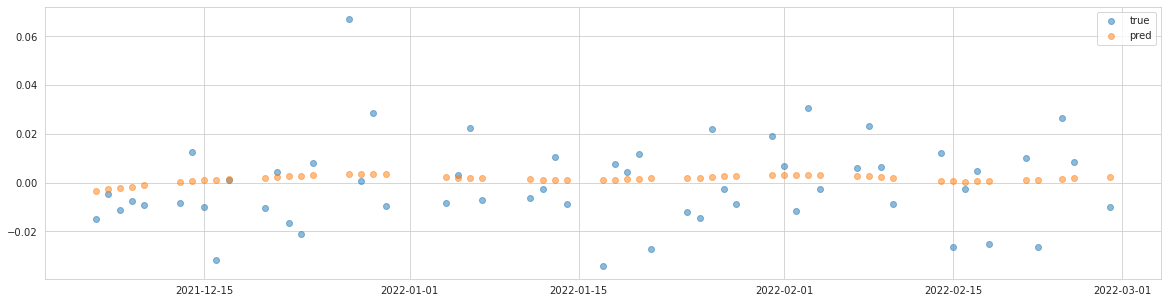

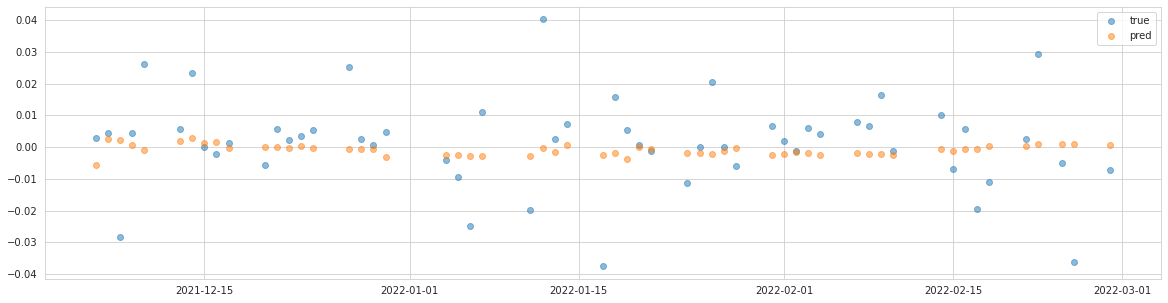

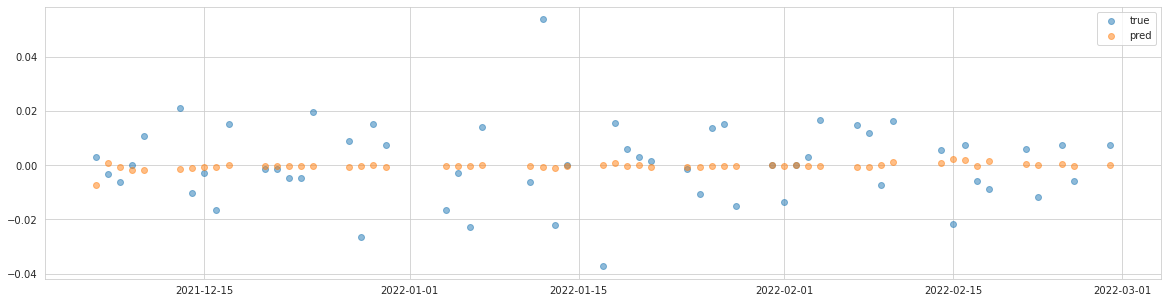

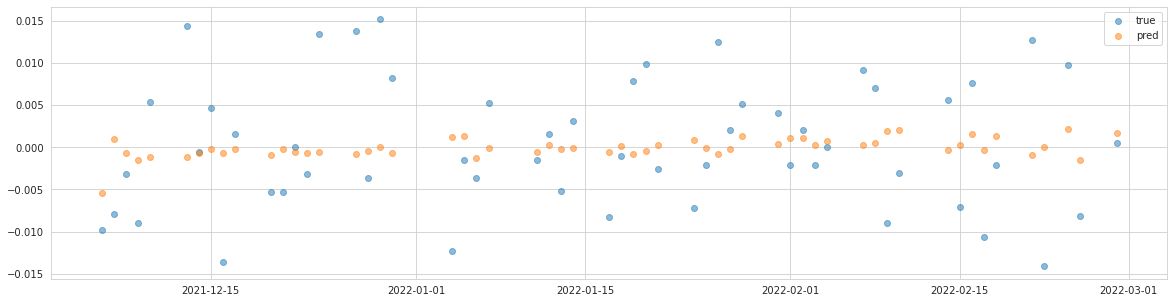

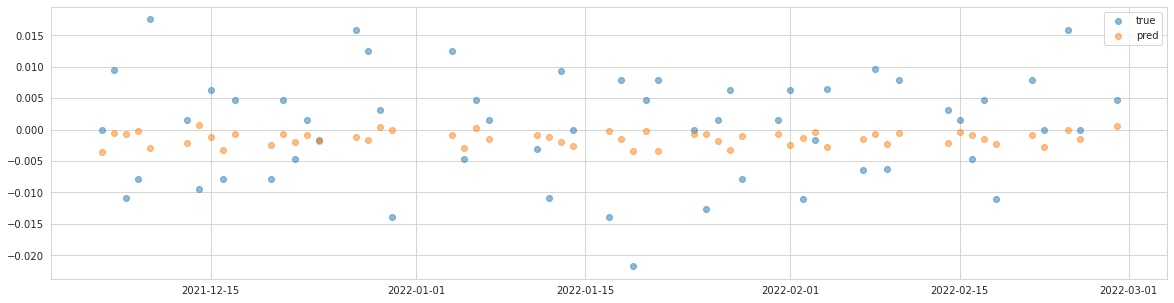

In [13]:
import matplotlib.pyplot as plt

recreated_target_is_valid = df_test_res.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (df_test_res.authentic == True)

for sc in df_test_res.SecuritiesCode.unique()[:8]:
    df = df_test_res[(df_test_res.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df.Date, df.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df.Date, df.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [14]:
from utilities.evaluation import calc_spread_return_sharpe

In [15]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_true_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.9333851997952436

In [16]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
calc_spread_return_sharpe(df_test_res)

0.10776509982286624